# Glance to Bernoulli and Gaussian Dropouts

In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.distributions.normal as normal

Choice of models can be made by `model = MaxBNet(p)` for Bernoullian dropout or `model = MaxGNet(si)` for Gaussian dropout

Dropout rates:

In [2]:
ps = np.array(np.arange(0.0, 1.0, 0.1))

The main run with dropout rates.

Variance for Gaussian dropout has this form:
$$
\sigma^2 = \frac{p}{1-p}
$$

In [3]:
accs = np.array([])
# load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print ('==>>> total trainning batch number: {}'.format(len(train_loader)))
print ('==>>> total testing batch number: {}'.format(len(test_loader)))

## network
###########################################################    
class MaxBNet(nn.Module):
    def __init__(self, p):
        super(MaxNet, self).__init__()
        self.p = p
        self.fc1 = nn.Sequential(nn.Linear(28*28, 256), 
                                 nn.Dropout(p))
                                 
        self.fc2 = nn.Sequential(nn.Linear(256, 10), 
                                 nn.Dropout(p))

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x    
    
    def name(self):
        return "MaxB"
###########################################################    
class MaxGNet(nn.Module):
    def __init__(self, si):
        super(MaxGNet, self).__init__()
        #self.mu = mu
        self.si = si
        self.fc1 = nn.Linear(28*28, 256)                                 
        self.fc2 = nn.Linear(256, 10)
        self.noise = normal.Normal(torch.tensor([1.]), torch.tensor([si]))
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = x*self.noise.sample()
        x = F.relu(x)
        x = self.fc2(x)
        x = x*self.noise.sample()
        return x    
    
    def name(self):
        return "MaxG"
###########################################################    
for p in ps:
    ## training
    si = np.sqrt(p/(1-p))
    #print('Dropout rate', p, si)
    #model = MaxBNet(p)
    model = MaxGNet(si)

    if use_cuda:
        model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.01)#, momentum=0.9)

    criterion = nn.CrossEntropyLoss()

    for epoch in range(1):
        # trainning
        ave_loss = 0
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                x, target = x.cuda(), target.cuda()
            x, target = Variable(x), Variable(target)
            out = model(x)
            loss = criterion(out, target)
            #ave_loss = ave_loss * 0.9 + loss.item() * 0.1
            loss.backward()
            optimizer.step()
            #if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            #    print ('==>>> epoch: {}, batch index: {}'.format(
            #        epoch, batch_idx+1))

    # computation of accuracy    
    ress = np.array([])
    for batch_idx, (x, target) in enumerate(test_loader):
        #if use_cuda:
        #    x, target = x.cuda(), target.cuda()
        with torch.no_grad():
            x, target = Variable(x), Variable(target)
        #x, target = Variable(x, volatile=True), Variable(target, volatile=True)    
        out = model(x)
        #break    
        res = np.array([])
        for i in range(batch_size):
            a = out.detach().numpy()[i]
            res = np.append(res, np.where(a==np.max(a))[0][0])
        b = target.detach().numpy()
        ress = np.append(ress, np.where((res-b).astype(bool)==True)[0].shape[0])
    acc = 1.0 - np.mean(ress)/100.0    
    accs = np.append(accs, acc)
    #print('Accuracy', acc)
    #print('=================')

==>>> total trainning batch number: 600
==>>> total testing batch number: 100


## Accuracy vs. dropout rate

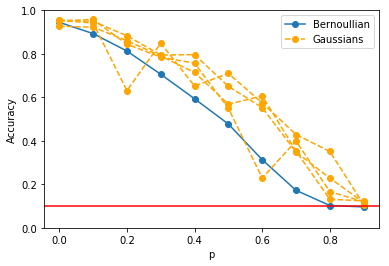

In [4]:
d = np.load('5epoch.npy')
plt.figure(figsize=(6,4))
color = 'orange'
plt.plot(ps, d[0], 'o-', label='Bernoullian')
#for data in d[1:]:
plt.plot(ps, d[1], 'o--', color=color, label='Gaussians')
plt.plot(ps, d[2], 'o--', color=color)
plt.plot(ps, d[3], 'o--', color=color)
plt.plot(ps, accs, 'o--', color=color)
plt.axhline(y=0.1, color='r', linestyle='-')
plt.ylim(0,1)
plt.xlabel(r'p')
plt.ylabel('Accuracy')
#plt.title('Accuracy vs. dropout rate')
plt.legend()